# Video inference

Loop on frames

Plot prob bargraph

Overlap text of class

Generate CAM video of heatmap overlayed

In [122]:
home_dir = '..\\'
baum_dir = home_dir + 'BAUM\\'
model_dir = baum_dir + 'models\\'
model_path  = model_dir + 'Model_fusion_05.h5'

In [123]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os, glob
import pandas as pd
import numpy as np

# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.display import clear_output

def update_progress(progress):
    bar_length = 75
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

C:\Users\HEMA\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [124]:

# load and evaluate a saved model
model = load_model(model_path)
# summarize model.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 44, 44, 32)   2432        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 44, 44, 32)   2432        input_4[0][0]                    
____________________________________________________________________________________________

In [125]:

data_labels_xl =  pd.read_excel(baum_dir +"Annotations_BAUM1s.xlsx")
data_labels = np.array(data_labels_xl)
print(len(data_labels))


1134


Taking random Image from  54410 images
(48, 48, 3) (48, 48, 3)
(1, 48, 48, 3) (1, 48, 48, 3)
4 [0. 0. 0. 1. 0. 0.]


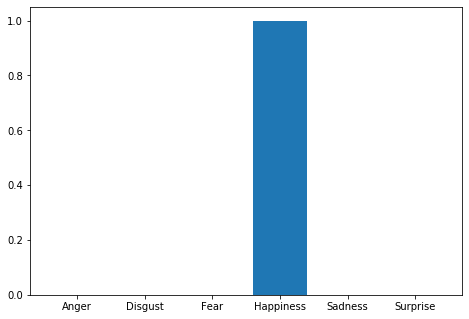

In [126]:
import cv2
import numpy as np
from glob import glob
from random import seed
from random import randint
import matplotlib.pyplot as plt

none_image = None

flow = baum_dir + 'imgs_flow\\'
spatial = baum_dir + 'imgs_spatial\\'

flowImgs = glob(flow+'*\\*\\*.png')
print("Taking random Image from ", len(flowImgs), "images")

data = pd.read_csv(baum_dir + 'validation_data_1a.csv', dtype={'flow': str, 'spatial': str, 'code': str})


emotions_code_arr = [1, 2, 3, 4, 5, 6]

s_codes = [1, 6, 7, 8, 10, 11] # for 1s
a_codes = [1, 3, 4, 5, 7, 8] 

def get_emotion_code(arr):
    emotions_code_arr = [1, 2, 3, 4, 5, 6]
    result_val = max(arr)
    result = list(arr).index(result_val)
    emotions_code = emotions_code_arr[result]
    return  emotions_code


val = randint(0, len(flowImgs))
img = flowImgs[val]
sample_name =img.split('\\')[-2]
for label in data_labels:
        if label[3] == sample_name and label[5] in s_codes:
            emotion = label[4]
            gt_code = label[5]
            gt_code = emotions_code_arr[s_codes.index(gt_code)]
            break
#print("Ground truth for " ,sample_name , " is : ", emotion, gt_code )

flowImg = cv2.imread(img)
spatialImg = cv2.imread(img.replace('imgs_flow','imgs_spatial'))

if (not isinstance(flowImg, type(none_image))) and (not isinstance(spatialImg, type(none_image))):
    flowImg = cv2.resize(flowImg, (48,48))
    spatialImg = cv2.resize(spatialImg, (48,48))
    flowImg = cv2.cvtColor(flowImg, cv2.COLOR_BGR2RGB)
    spatialImg = cv2.cvtColor(spatialImg, cv2.COLOR_BGR2RGB)
    print (flowImg.shape, spatialImg.shape)
    flowImg = flowImg.reshape(-1, 48,48,3)
    spatialImg = spatialImg.reshape(-1, 48,48,3)
    print(spatialImg.shape, flowImg.shape)
    out = model.predict([spatialImg, flowImg])

print(gt_code,out[0] )
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness','Sadness', 'Surprise']
ax.bar(emotions,out[0])
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
from glob import glob
from random import seed
from random import randint
import matplotlib.pyplot as plt

none_image = None

flow = baum_dir + 'imgs_flow\\'
spatial = baum_dir + 'imgs_spatial\\'

flowImgs = glob(flow+'*\\*\\*.png')
print("Taking 100 random Images from ", len(flowImgs), "images")

s_codes = [1, 6, 7, 8, 10, 11] # for 1s
a_codes = [1, 3, 4, 5, 7, 8] 
emotions_code_arr = [1, 2, 3, 4, 5, 6]

#emotions_code_arr = [1, 10, 11, 6, 7, 8]
def get_emotion_code(arr):
    result_val = max(arr)
    result = list(arr).index(result_val)
    emotions_code = emotions_code_arr[result]
    return  emotions_code


good_prediction = 0
bad_prediction = 0
i = 0
outs = []
gt = []
data = pd.read_csv(baum_dir + 'training_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})
img = data['flow'][0]
print (baum_dir + img)


while i < len(data):
  update_progress(float(i+1)/len(data))
  val = i #randint(0, len(data)-1)
  img = baum_dir + data['flow'][val]#,data['spatial'][i],data['code'][i]
  sample_name = img.split('\\')[-2]
  for label in data_labels:
          if label[3] == sample_name and label[5] in s_codes:
            emotion = label[4]
            gt_code = label[5]
            gt_code = emotions_code_arr[s_codes.index(gt_code)] #1-6
            #print(gt_code, data['code'][val])
            break
  if label[5] not in s_codes:
    #i-=1
    continue
  #print img 
  flowImg = cv2.imread(img)
  spatialImg = cv2.imread(img.replace('imgs_flow','imgs_spatial'))
  if (not isinstance(flowImg, type(none_image))) and (not isinstance(spatialImg, type(none_image))):
      i+=1
      flowImg = cv2.resize(flowImg, (48,48))
      spatialImg = cv2.resize(spatialImg, (48,48))
      flowImg = flowImg / 255.
      spatialImg = spatialImg / 255.
      flowImg = flowImg.reshape(-1, 48,48,3)
      spatialImg = spatialImg.reshape(-1, 48,48,3)
      out = model.predict([spatialImg, flowImg])
      outs.append(out[0])
      gt.append(emotions_code_arr.index(gt_code))  #0-5

      emotions_code = get_emotion_code(out[0])
        
      #print ( gt_code,emotions_code, out[0])
      
      if emotions_code == gt_code:
          good_prediction += 1
      else:
          bad_prediction += 1


print("acuuracy is: ", 100 *good_prediction/(good_prediction+bad_prediction), "%" )

y_predict = np.argmax(outs, axis=1)
cm = confusion_matrix(gt, y_predict)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d")


Progress: [#############################----------------------------------------------] 38.8%


# Test on Video

In [ ]:
# Needed Functions
# Create a face detec tion module 
calssifiers =['haarcascade_frontalface_default.xml',
              'haarcascade_frontalface_alt2.xml',
              'haarcascade_frontalcatface_extended.xml',
              'haarcascade_frontalcatface.xml',
              'haarcascade_frontalface_alt_tree.xml',
              'haarcascade_frontalface_alt.xml']

#home_dir = '/content/drive/My Drive/Colab Notebooks/FER/'
#baum_dir = home_dir + "BAUM/"
def detectFace(img):
    for classifier in calssifiers:
        face_cascade = cv2.CascadeClassifier(home_dir +'face_detectors\\' + classifier)
        faces = face_cascade.detectMultiScale(img, 1.3, 1)
        if (len(faces) > 0):
            return faces
    faces = []
    return faces

# Test On Trained Classes

In [ ]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from google.colab.patches import cv2_imshow
from random import randint
#seed(2)

videos = glob(baum_dir+'BAUM1s_MP4 - All\\*\\*.mp4')
emotions = ['Anger', 'Sadness', 'Surprise', 'Disgust', 'Fear', 'Happiness']

data_labels_xl =  pd.read_excel(baum_dir + "Annotations_BAUM1s.xlsx")
data_labels = np.array(data_labels_xl)

#print (vid)
# Assert Video Code
val = randint(0, len(videos)-1)
#print (len(videos))
vid = videos[val]
vidName = vid.split('\\')[-1].split('.')[0]
vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])

while vidCode not in ([1, 10, 11, 6, 7, 8]):
  val = randint(0, len(videos))
  vid = videos[val]
  vidName = vid.split('\\')[-1].split('.')[0]
  #print (vidName)
  try:
    vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
    vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])
  except:
    print ("Video Emotion Not Found")
print ('Video Name: {} Label: {}'.format(vidName, vidLabel))

cap = cv2.VideoCapture(vid)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

temp_image = np.array([])
none_image = None

noFacesCnt = 0
calcOpticalFlow = 0
for i in range(frameCount):
    print ('Frame: {}/{}'.format(i, frameCount))
    ret,frame = cap.read()
    if isinstance(frame, type(temp_image)) and not isinstance(frame, type(none_image)) :
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detectFace(frame_gray)
        if len(faces) == 0:
            calcOpticalFlow = 0
            noFacesCnt += 1
            continue

        (x,y,w,h)  = faces[0]
        frame_gray = frame_gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]

        if(frame_gray.shape[0] < 90 or roi_color.shape[0] < 90 ):
            calcOpticalFlow = 0
            continue

        #print(frame_gray.shape)
        frame_gray = cv2.resize(frame_gray, (100,100))
        roi_color = cv2.resize(roi_color, (100,100))
        #print(frame_gray.shape, "after")

        calcOpticalFlow += 1
        hsv = np.zeros_like(roi_color)
        hsv[...,1] = 255

        if (calcOpticalFlow > 1):
            flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)            
            mag, ang   = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            
            flowImg = cv2.resize(rgb, (48,48))
            flowImg = flowImg.reshape(-1, 48,48,3)
            roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
            spatialImg = cv2.resize(roi_color, (48,48))
            spatialImg = spatialImg.reshape(-1, 48,48,3)
            out = model.predict([spatialImg, flowImg])
            print ('True: {}, Out: {}, Prob.: {}'.format(vidLabel, emotions[np.argmax(out[0])], out[0]))
            #print ('Emotion {}'.format(vidLabel))
            cv2_imshow(cv2.cvtColor(roi_color, cv2.COLOR_RGB2BGR))
            #cv2.waitKey(0)
        old_gray = frame_gray.copy()

# Test on UnSure Emotion Video

In [ ]:
import cv2
import numpy as np
from glob import glob
import pandas as pd
from google.colab.patches import cv2_imshow
from random import randint
seed(2)

videos = glob(baum_dir+'BAUM1s_MP4 - All\\*\\*.mp4')
emotions = ['Anger', 'Sadness', 'Surprise', 'Disgust', 'Fear', 'Happiness']

data_labels_xl =  pd.read_excel(baum_dir + "Annotations_BAUM1s.xlsx")
data_labels = np.array(data_labels_xl)

#print (vid)
# Assert Video Code
val = randint(0, len(videos)-1)
#print (len(videos))
vid = videos[val]
vidName = vid.split('/')[-1].split('.')[0]
vidLabel = str(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion'].values[0])
vidCode = int(data_labels_xl.loc[data_labels_xl['Clip Name'] == vidName]['Emotion Code'].values[0])

print ('Video Name: {} Label: {}'.format(vidName, vidLabel))

cap = cv2.VideoCapture(vid)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

temp_image = np.array([])
none_image = None

noFacesCnt = 0
calcOpticalFlow = 0
for i in range(frameCount):
    print ('Frame: {}/{}'.format(i, frameCount))
    ret,frame = cap.read()
    if isinstance(frame, type(temp_image)) and not isinstance(frame, type(none_image)) :
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detectFace(frame_gray)
        if len(faces) == 0:
            calcOpticalFlow = 0
            noFacesCnt += 1
            continue

        (x,y,w,h)  = faces[0]
        frame_gray = frame_gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]

        if(frame_gray.shape[0] < 90 or roi_color.shape[0] < 90 ):
            calcOpticalFlow = 0
            continue

        #print(frame_gray.shape)
        frame_gray = cv2.resize(frame_gray, (100,100))
        roi_color = cv2.resize(roi_color, (100,100))
        #print(frame_gray.shape, "after")

        calcOpticalFlow += 1
        hsv = np.zeros_like(roi_color)
        hsv[...,1] = 255

        if (calcOpticalFlow > 1):
            flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)            
            mag, ang   = cv2.cartToPolar(flow[...,0], flow[...,1])
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            
            flowImg = cv2.resize(rgb, (48,48))
            flowImg = flowImg.reshape(-1, 48,48,3)
            roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
            spatialImg = cv2.resize(roi_color, (48,48))
            spatialImg = spatialImg.reshape(-1, 48,48,3)
            out = model.predict([spatialImg, flowImg])
            print ('True: {}, Out: {}, Prob.: {}'.format(vidLabel, emotions[np.argmax(out[0])], out[0]))
            #print ('Emotion {}'.format(vidLabel))
            cv2_imshow(cv2.cvtColor(roi_color, cv2.COLOR_RGB2BGR))
            #cv2.waitKey(0)
        old_gray = frame_gray.copy()

In [ ]:
data = pd.read_csv(baum_dir + 'training_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})

In [74]:
from sklearn import model_selection
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

data = pd.read_csv(baum_dir + 'training_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})
#data_valid = pd.read_csv(baum_dir + 'validation_data_1s.csv', dtype={'flow': str, 'spatial': str, 'code': str})


train_df, valid_df = model_selection.train_test_split(data, test_size=0.25)

print("idx 100 before shuffle", data[100:101])
print("idx 100 before shuffle", data[100:101])
print("idx 100 before shuffle", data[100:101])


data = shuffle(data)
print("idx 100 after shuffle", data[100:101])
data_valid = shuffle(valid_df)
print(len(data))
print(len(data_valid))
print("----")

batch_size_ = 256

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_spatial = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

validation_generator_spatial = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="spatial",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

train_generator_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

validation_generator_flow = test_datagen.flow_from_dataframe(
        dataframe=valid_df,
        seed = 1,
        directory=baum_dir,
        x_col="flow",
        y_col="code",
        target_size=(48, 48),
        batch_size=batch_size_,
        class_mode='categorical')

def combine_generator(gen1, gen2):
    while True:    
        X1i = gen1.next()
        X2i = gen2.next()

        frame = X1i[0][0]

        #cv2.imwrite( str(X1i[1][0]) +".png",frame )
        #cv2.imwrite("f.png", X2i[0][0])
        yield [X1i[0], X2i[0]], X1i[1]  #X1i[1] is the label


train_generator = combine_generator(train_generator_spatial, train_generator_flow)
validation_generator = combine_generator(validation_generator_spatial, validation_generator_flow)


print ("generators initiaized")

idx 100 before shuffle                                 flow                             spatial  \
100  imgs_flow\s001\S001_010\118.png  imgs_spatial\s001\S001_010\118.png   

       emotion code  
100  Happiness    4  
idx 100 before shuffle                                 flow                             spatial  \
100  imgs_flow\s001\S001_010\118.png  imgs_spatial\s001\S001_010\118.png   

       emotion code  
100  Happiness    4  
idx 100 before shuffle                                 flow                             spatial  \
100  imgs_flow\s001\S001_010\118.png  imgs_spatial\s001\S001_010\118.png   

       emotion code  
100  Happiness    4  
idx 100 after shuffle                                  flow                             spatial  \
5544  imgs_flow\s003\S003_027\088.png  imgs_spatial\s003\S003_027\088.png   

      emotion code  
5544  Sadness    5  
46902
11726
----
Found 35176 validated image filenames belonging to 6 classes.
Found 11726 validated image filenames belo

In [77]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.evaluate_generator(validation_generator, 20, verbose=1)

y_pred = np.argmax(Y_pred, axis=0)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.code, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred)) #, target_names=target_names))

20/20 [==============================] - 18s 902ms/step - loss: 0.7410 - acc: 0.7032
Confusion Matrix


AttributeError: 'generator' object has no attribute 'code'

In [115]:
img = baum_dir + data['spatial'][1]
print (img)

pic = cv2.imread(img)
print (pic/255.)

..\BAUM\imgs_spatial\s009\S009_015\002.png
[[[0.30588235 0.81568627 0.09411765]
  [0.30588235 0.81568627 0.09411765]
  [0.30588235 0.81568627 0.09411765]
  ...
  [0.31764706 0.82352941 0.09019608]
  [0.31764706 0.82352941 0.09019608]
  [0.31764706 0.82352941 0.09019608]]

 [[0.30588235 0.81568627 0.09411765]
  [0.30588235 0.81568627 0.09411765]
  [0.30588235 0.81568627 0.09411765]
  ...
  [0.31764706 0.82352941 0.09019608]
  [0.31764706 0.82352941 0.09019608]
  [0.31764706 0.82352941 0.09019608]]

 [[0.30588235 0.81568627 0.09411765]
  [0.30588235 0.81568627 0.09411765]
  [0.30588235 0.81568627 0.09411765]
  ...
  [0.31764706 0.82352941 0.09019608]
  [0.31764706 0.82352941 0.09019608]
  [0.31764706 0.82352941 0.09019608]]

 ...

 [[0.27843137 0.75294118 0.08235294]
  [0.27843137 0.75294118 0.08235294]
  [0.27843137 0.74901961 0.08627451]
  ...
  [0.27058824 0.74117647 0.07843137]
  [0.27058824 0.74117647 0.07843137]
  [0.27058824 0.74117647 0.07843137]]

 [[0.27843137 0.75294118 0.0823